In [1]:
import os 
import scanpy as sc

In [2]:
thor_dir = "/Users/pengzhizhang/HF_Lai_normalize/Heart_II"

In [ ]:
ad_s1_path = os.path.join(thor_dir, "fineST_s1/s1_thor_adata_20.h5ad")
ad_thor_s1 = sc.read_h5ad(ad_s1_path)

ad_s2_path = os.path.join(thor_dir, "fineST_s2/s2_thor_adata_20.h5ad")
ad_thor_s2 = sc.read_h5ad(ad_s2_path)

ads = {'s1': ad_thor_s1, 's2': ad_thor_s2}

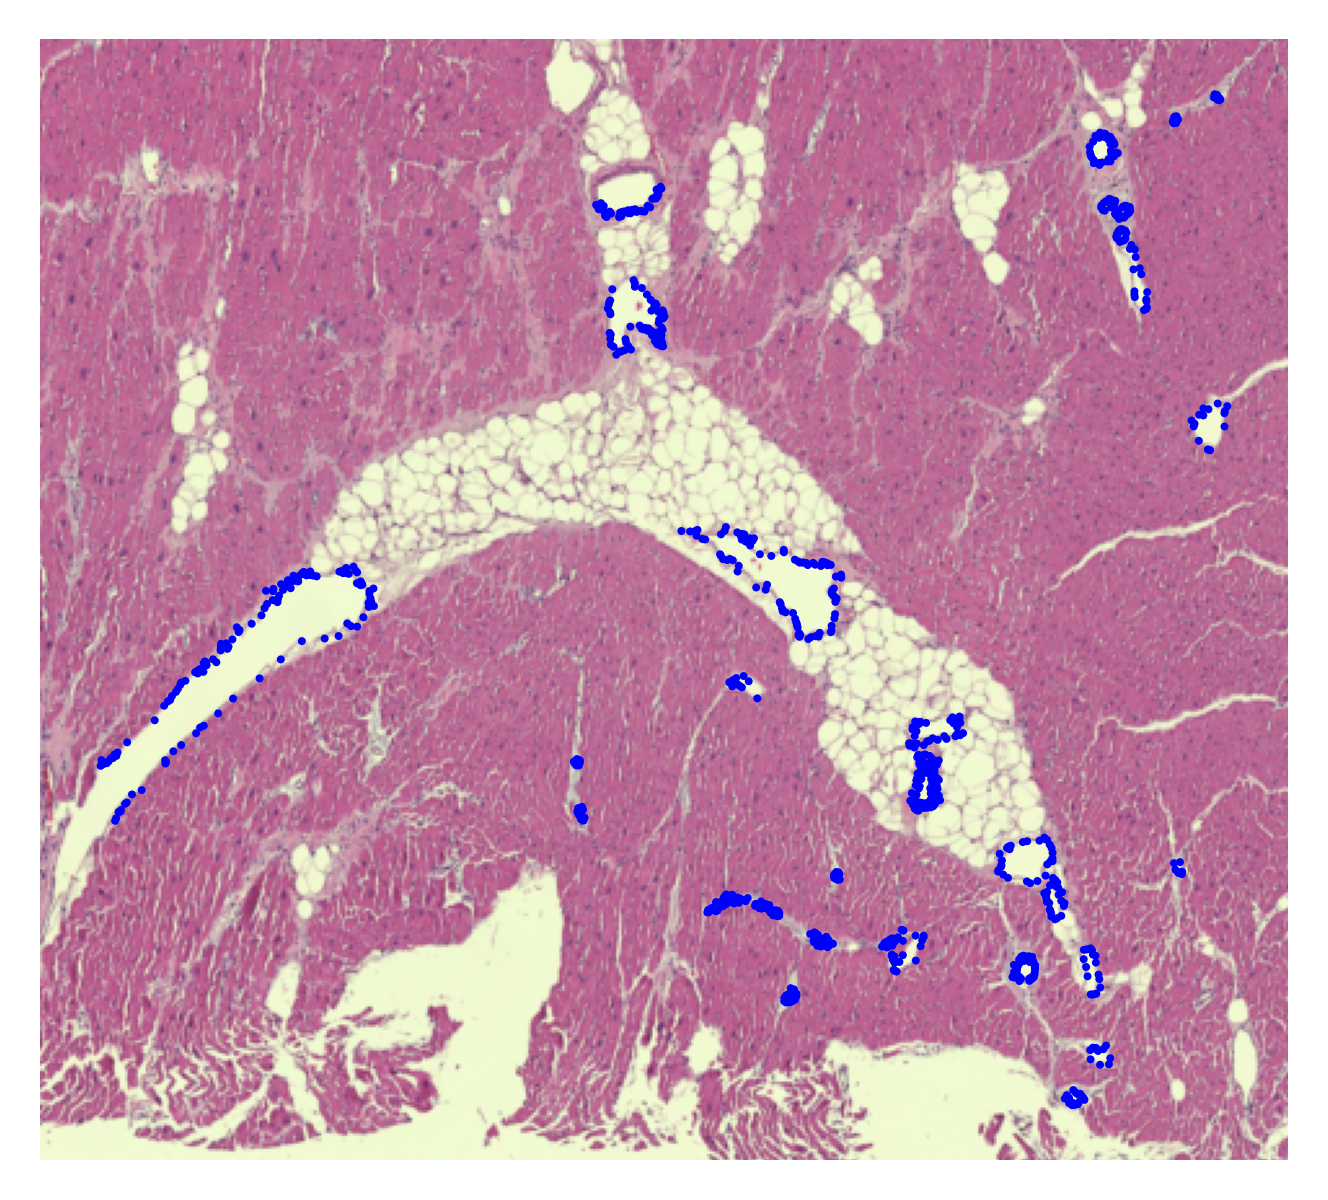

In [ ]:
sc.set_figure_params(dpi=200)

ad_thor_s1_vis = ad_thor_s1[ad_thor_s1.obs['ROI'] != 'Unselected'].copy()
sc.pl.spatial(ad_thor_s1_vis, color='in_tissue', spot_size=50, legend_loc=None, palette='b', save='thor_s1_vessel_tissue.png', frameon=False, title="")

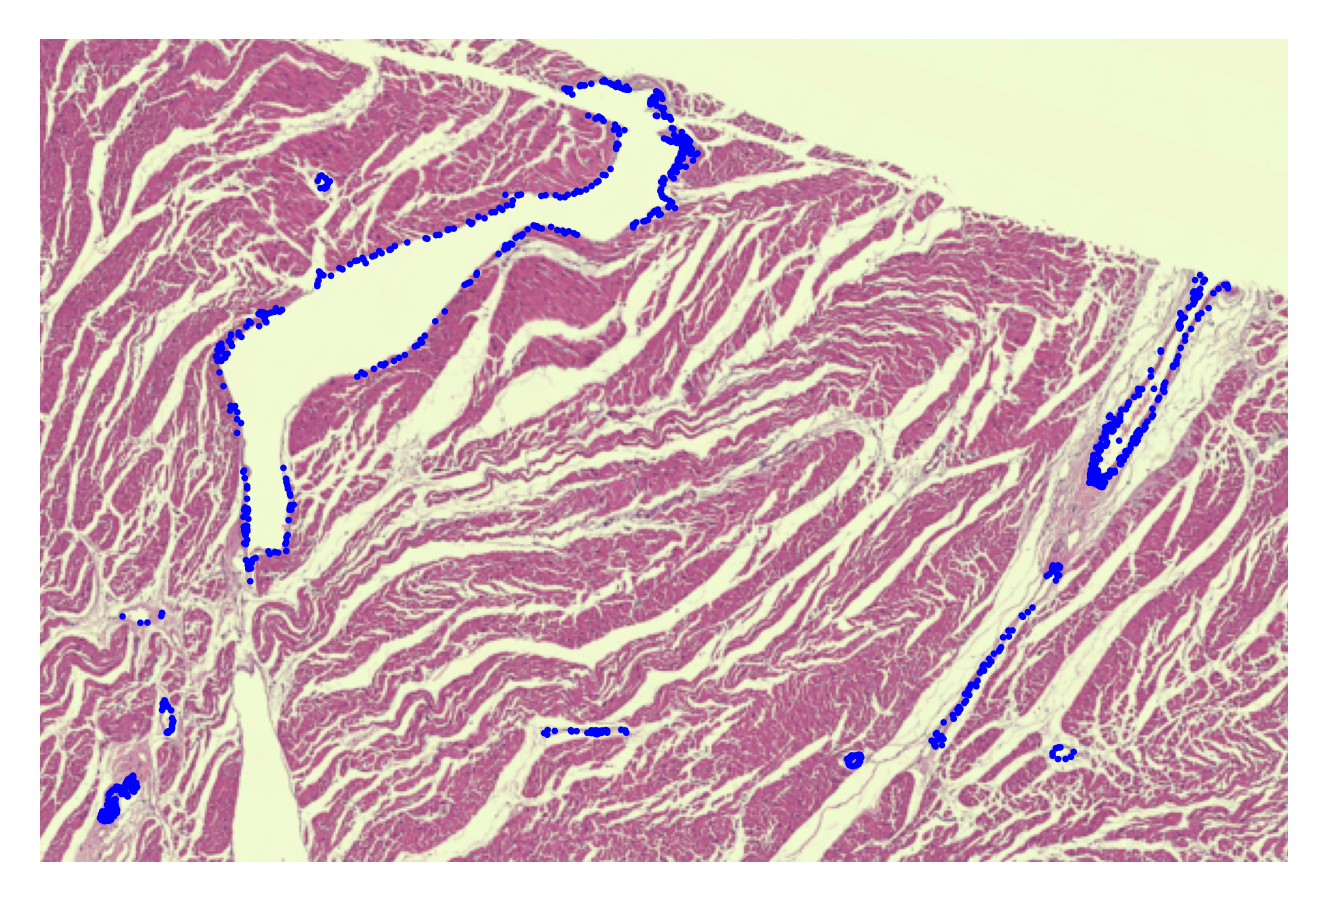

In [ ]:
sc.set_figure_params(dpi=200)

ad_thor_s2_vis = ad_thor_s2[ad_thor_s2.obs['ROI'] != 'Unselected'].copy()
sc.pl.spatial(ad_thor_s2_vis, color='in_tissue', spot_size=50, legend_loc=None, palette='b', save='thor_s2_vessel_tissue.png', frameon=False, title="")

### Differentially expressed genes

In [ ]:
from matplotlib import pyplot as plt

ad_thor_s1.obs['vessel'] = ad_thor_s1.obs['ROI'].apply(lambda x: 'vessels' if x != 'Unselected' else 'rest')
sc.tl.rank_genes_groups(ad_thor_s1, groupby='vessel', groups=['vessels'], reference='rest')

In [13]:
df_s1 = sc.get.rank_genes_groups_df(
    ad_thor_s1, 'vessels', pval_cutoff=0.05, log2fc_min=2
)

df_s1

names     scores  logfoldchanges          pvals      pvals_adj
0        FOS  52.668034        2.109415  2.482293e-295  2.067986e-293
1      CSRP1  49.961906        2.066983  2.743450e-274  1.745333e-272
2      TAGLN  47.919743        2.824694  5.655388e-261  3.067938e-259
3      ADIRF  47.497559        2.303736  2.382163e-259  1.253412e-257
4      ACTA2  44.337776        2.687633  1.454849e-237  5.919207e-236
..       ...        ...             ...            ...            ...
325     HBA2   6.213837        2.444723   7.671364e-10   1.214025e-09
326   NBPF19   6.211482        2.141423   7.768051e-10   1.228771e-09
327      LHB   6.088478        2.338549   1.640759e-09   2.571563e-09
328      DCD   5.827083        2.157739   7.660175e-09   1.173509e-08
329  CLLU1OS   3.834708        2.108645   1.338109e-04   1.729253e-04

[330 rows x 5 columns]

In [171]:
with open("Post-DEG-s1_genes.txt", "w") as f:
    for g in df_s1.names:
        f.write(g+"\n")

In [ ]:
ad_thor_s2.obs['vessel'] = ad_thor_s2.obs['ROI'].apply(lambda x: 'vessels' if x != 'Unselected' else 'rest')
sc.tl.rank_genes_groups(ad_thor_s2, groupby='vessel', groups=['vessels'], reference='rest')

df_s2 = sc.get.rank_genes_groups_df(
    ad_thor_s2, 'vessels', pval_cutoff=0.05, log2fc_min=2
    )
df_s2

names     scores  logfoldchanges          pvals      pvals_adj
0       VIM  46.983665        2.176891  2.094893e-241  2.255394e-239
1     TAGLN  40.533535        3.405335  3.052961e-202  2.094571e-200
2      CCN2  39.958858        2.640185  6.208515e-199  4.137828e-197
3      CCN1  39.192749        2.345033  2.931582e-194  1.865019e-192
4    COL3A1  38.760052        2.244384  8.892323e-192  5.411172e-190
..      ...        ...             ...            ...            ...
512  RASA4B   5.727336        2.327418   1.409894e-08   2.095675e-08
513    CHGA   5.650852        2.000702   2.170150e-08   3.189815e-08
514    MAS1   5.495721        2.892391   5.129023e-08   7.442028e-08
515  IZUMO2   5.218079        2.336282   2.267150e-07   3.220117e-07
516    VIL1   5.159015        2.191676   3.082824e-07   4.352149e-07

[517 rows x 5 columns]

In [ ]:
with open("Post-DEG-s2_genes.txt", "w") as f:
    for g in df_s2.names:
        f.write(g+"\n")

In [ ]:
common_genes = set(df_s2['names']) & set(df_s1['names'])

with open('Post-DEG-vessel_common_genes_new.txt', 'w') as f:
    for g in common_genes:
        f.write(g+'\n')

### Rank the genes

In [ ]:
common_genes = set(df_s2['names']) & set(df_s1['names'])
print(len(common_genes))

56


In [ ]:
# combine df_s1 and df_s2 and calculate the averages for the score, logfoldchange and pvals

df_s1 = df_s1[df_s1['names'].isin(common_genes)].copy()
df_s2 = df_s2[df_s2['names'].isin(common_genes)].copy()

df_s1['s1_score'] = df_s1['scores']
df_s1['s1_logfoldchange'] = df_s1['logfoldchanges']
df_s1['s1_pvals'] = df_s1['pvals']

df_s2['s2_score'] = df_s2['scores']
df_s2['s2_logfoldchange'] = df_s2['logfoldchanges']
df_s2['s2_pvals'] = df_s2['pvals']

df_s1 = df_s1[['names', 's1_score', 's1_logfoldchange', 's1_pvals']]
df_s2 = df_s2[['names', 's2_score', 's2_logfoldchange', 's2_pvals']]
df = df_s1.merge(df_s2, on='names', how='outer')

df['avg_score'] = (df['s1_score'] + df['s2_score']) / 2
df['avg_logfoldchange'] = (df['s1_logfoldchange'] + df['s2_logfoldchange']) / 2
df['avg_pvals'] = (df['s1_pvals'] + df['s2_pvals']) / 2

df = df.sort_values(by='avg_score', ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


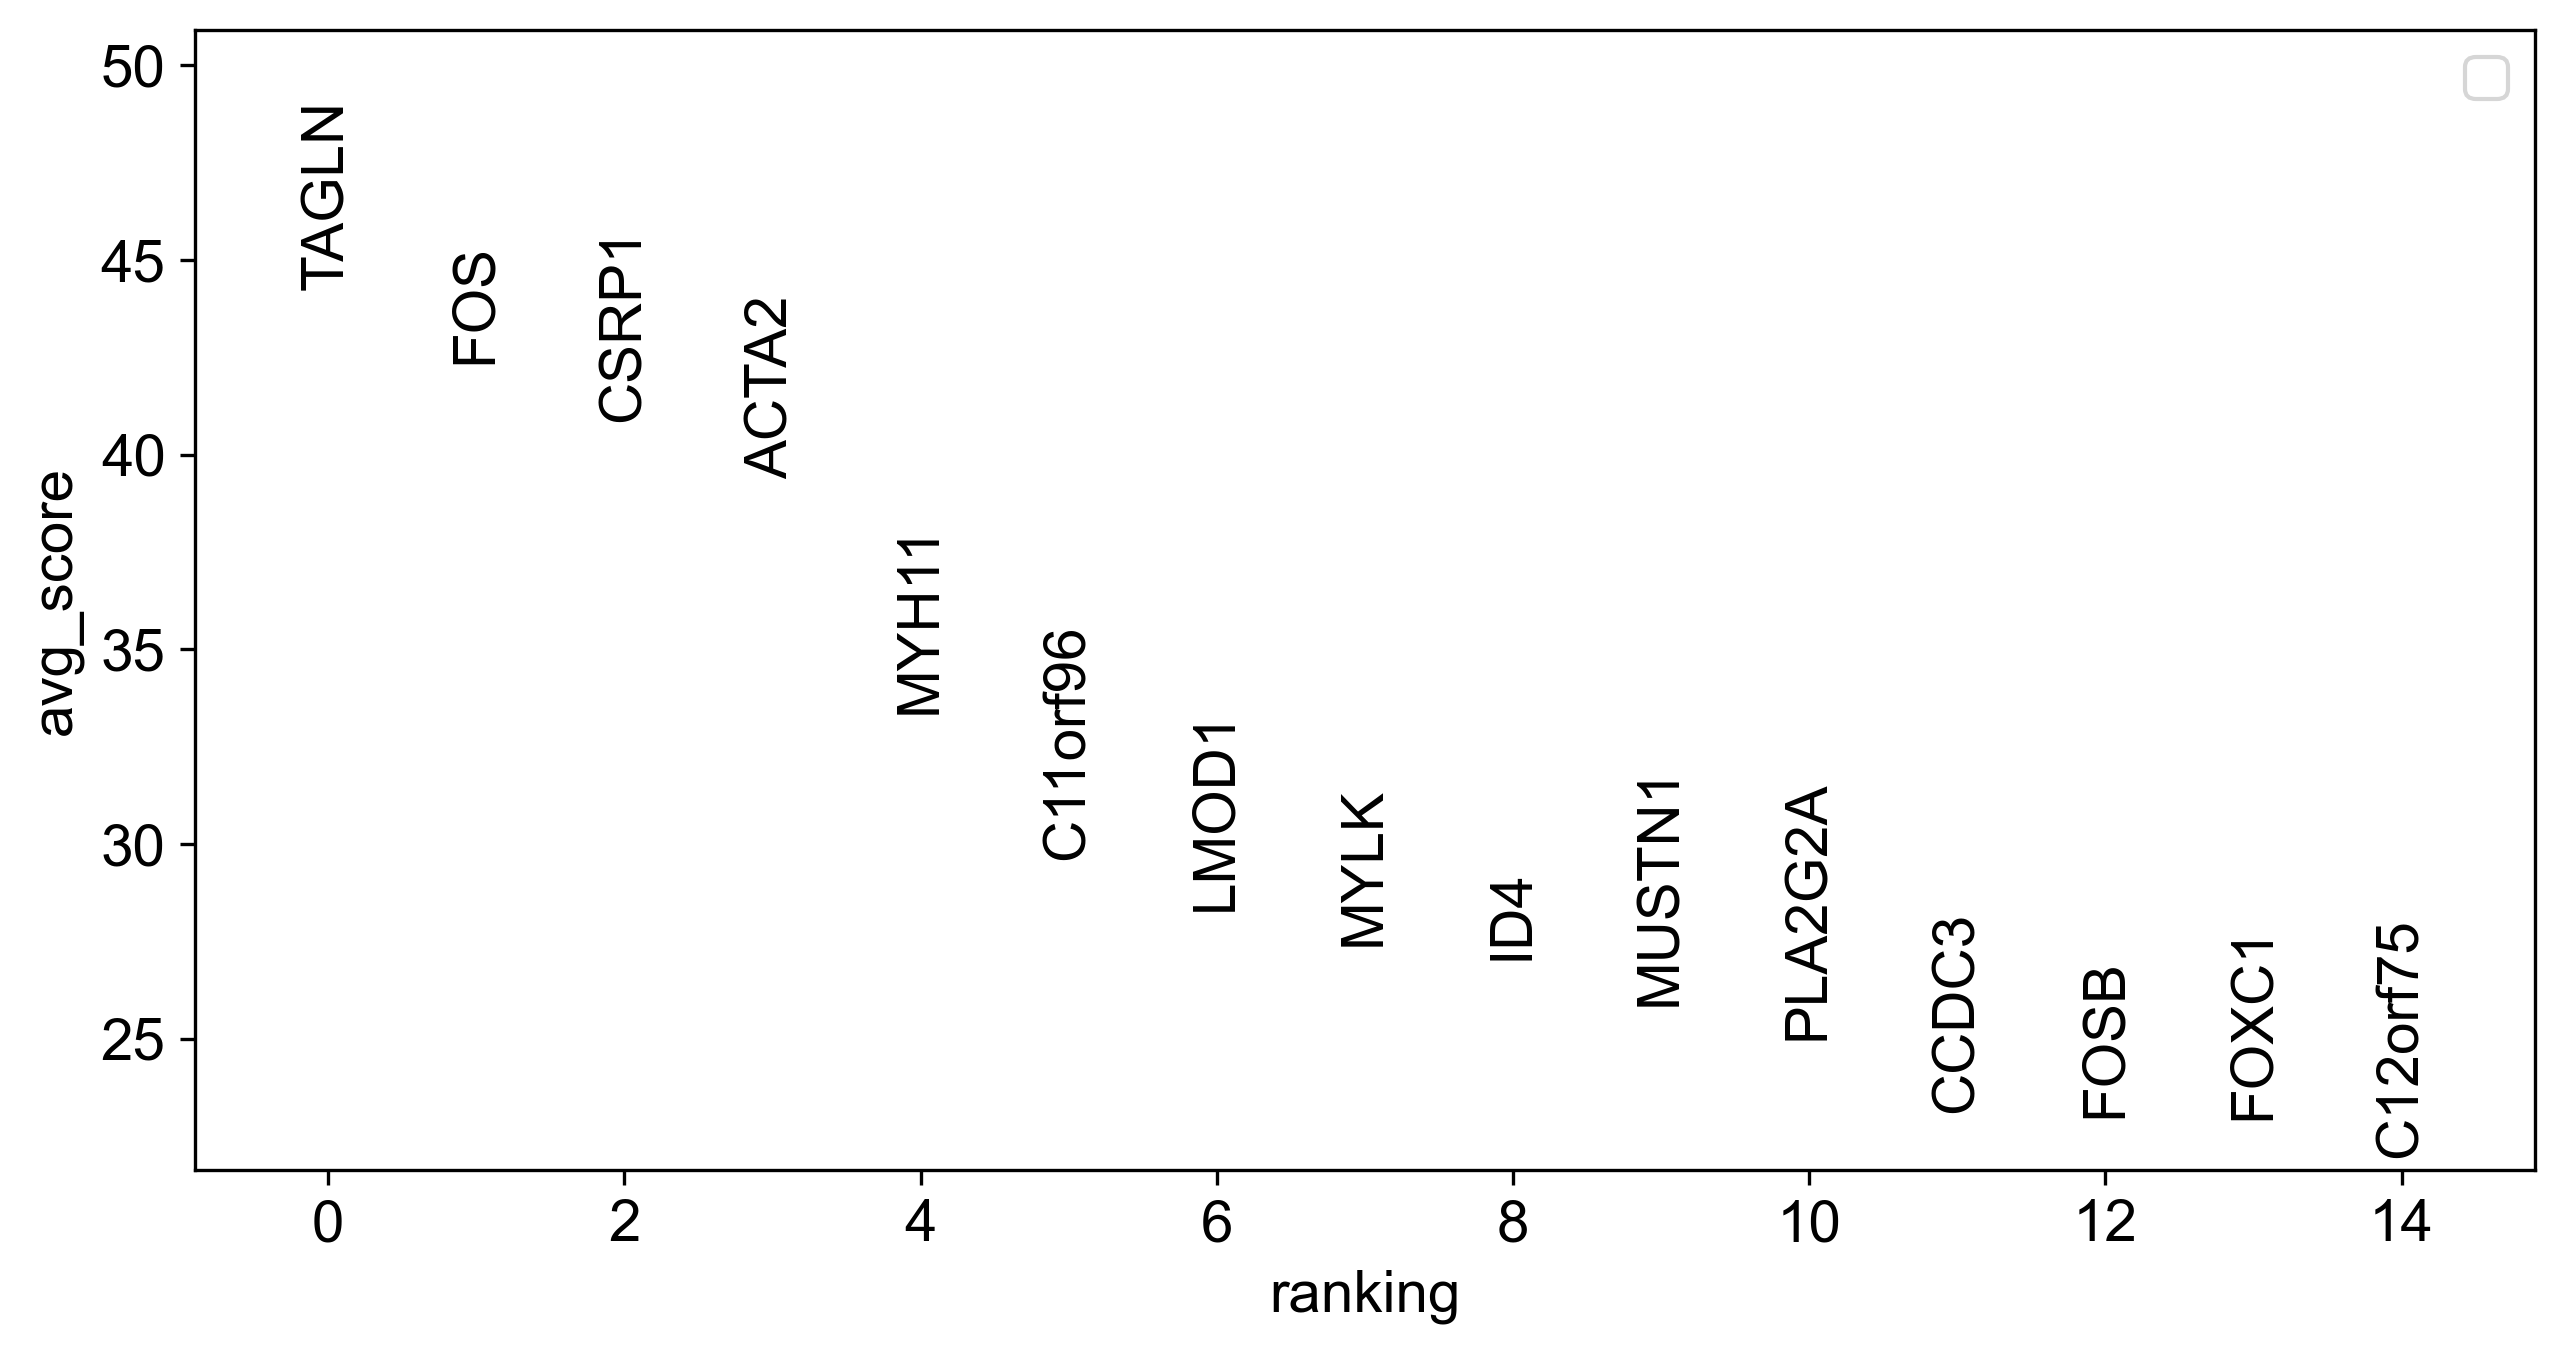

In [80]:
# plot the results
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
n_genes = 15

gene_names = df['names'].tolist()[:n_genes]
scores = df['avg_score'].tolist()[:n_genes]

ymin = np.min(scores)
ymax = np.max(scores)
ymax += 0.3 * (ymax - ymin)
ax = fig.add_subplot()
ax.set_ylim(ymin-0.3, ymax)
ax.set_xlim(-0.9, n_genes - 0.1)

# Making labels
for ig, gene_name in enumerate(gene_names):
    ax.text(
        ig,
        scores[ig],
        gene_name,
        rotation="vertical",
        verticalalignment="bottom",
        horizontalalignment="center",
        fontsize=14,
    )


plt.xlabel('ranking')
plt.ylabel('avg_score')
plt.legend()

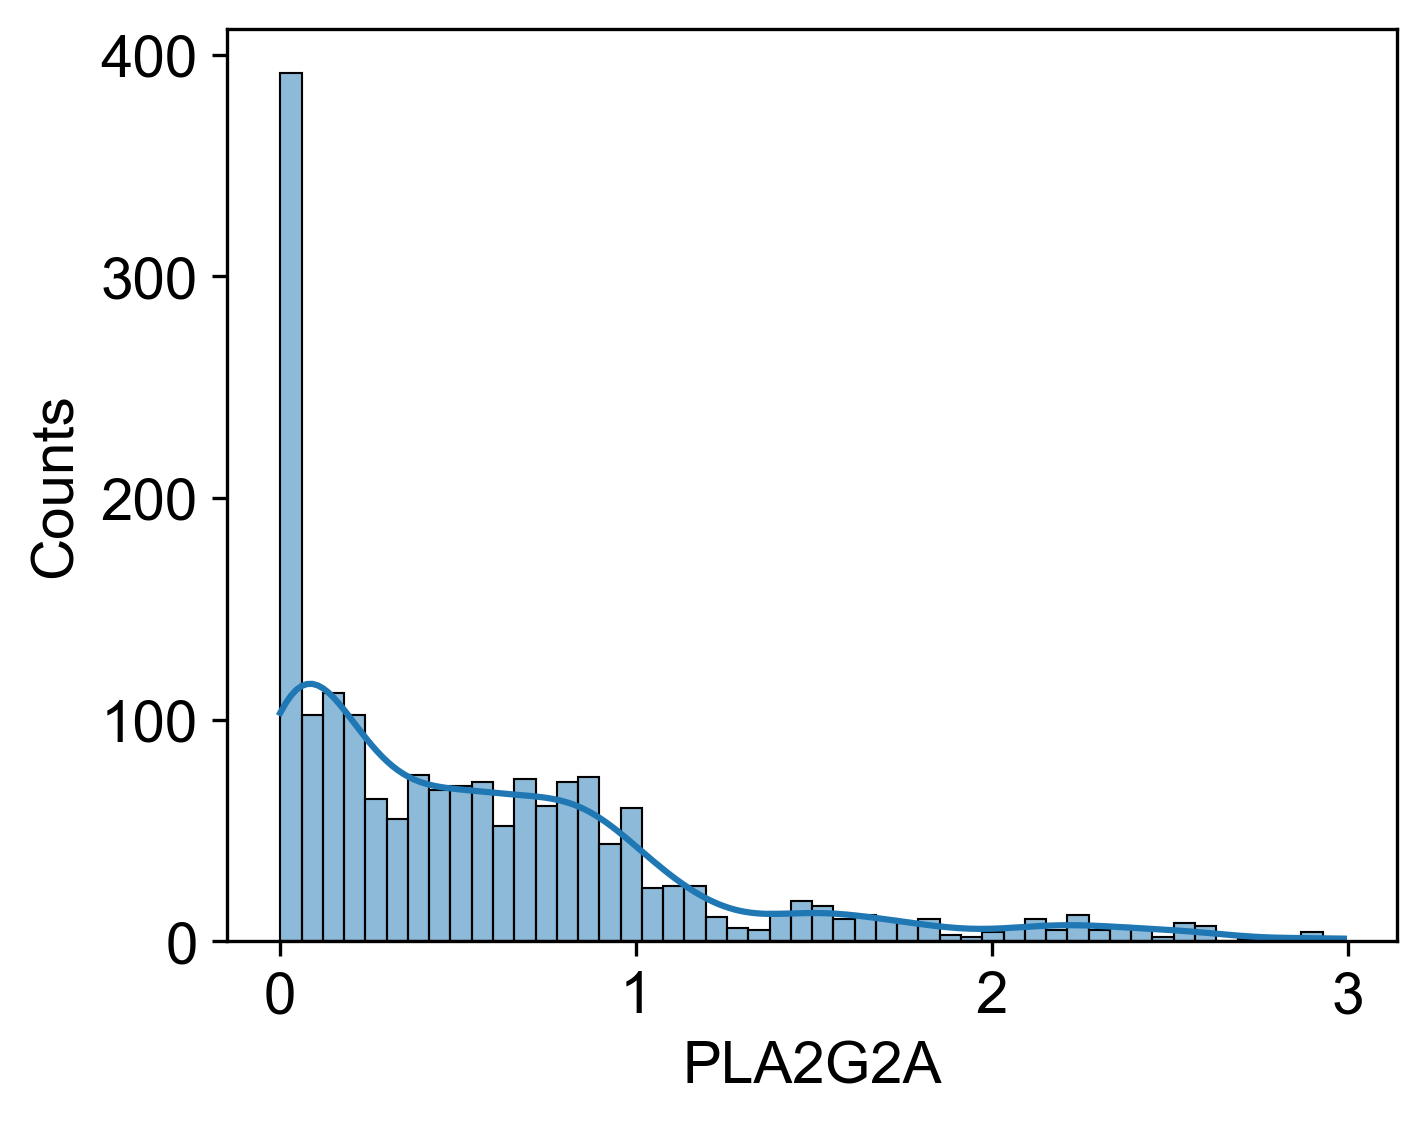

In [ ]:
import seaborn as sns

plt.figure(figsize=(5, 4))
tag1 = ad_thor_s1_vis[:, 'PLA2G2A'].X.toarray().flatten()
tag3 = ad_thor_s2_vis[:, 'PLA2G2A'].X.toarray().flatten()
tag = np.concatenate([tag1, tag3])
sns.histplot(tag, kde=True, bins=50)
plt.xlabel('PLA2G2A')
plt.ylabel('Counts')
plt.show()